### Fitting Matrix entries
In this Notebook the matrix entries for both half-wave plates were fitted using least squares fits. In this version only the diagonal entries are non-zero. Additionally they are bounded between -1 and 1. The matrix used for the fits looks like $$\begin{bmatrix}
 a_{11} & 0 & 0 & 0\\
0 & a_{22} & 0 & 0\\
 0 & 0 & a_{33}& 0 \\
  0 & 0 & 0 & a_{44}
\end{bmatrix}$$ and a $\in$ [-1,1]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sympy import Symbol, cos, sin, pi, sqrt, symbols, acos, asin
from sympy.matrices import *
from sympy.utilities.lambdify import lambdify
from sympy.interactive.printing import init_printing
from sympy.interactive import printing
printing.init_printing(use_latex=True)

from scipy.optimize import curve_fit, minimize

import os
from os.path import join, getsize


# The function and class below are just for formatting of the plots
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

# define symbols
theta = Symbol('theta') # angle for rotation matrix
theta_0 = Symbol('theta_0') # angle for unknown main axis of the waveplate
a11 = Symbol('a_11')
a12 = Symbol('a_12')
a13 = Symbol('a_13')
a14 = Symbol('a_14')
a21 = Symbol('a_21')
a22 = Symbol('a_22')
a23 = Symbol('a_23')
a24 = Symbol('a_24')
a31 = Symbol('a_31')
a32 = Symbol('a_32')
a33 = Symbol('a_33')
a34 = Symbol('a_34')
a41 = Symbol('a_41')
a42 = Symbol('a_42')
a43 = Symbol('a_43')
a44 = Symbol('a_44')

Define rotation and Müller matrices. Replace some entries of the general Müller matrix with values from the theoretical prediction for a better fit. In the rotation matrix an additional parameter $\Theta_{0}$
was introduced to account for the unknown main axis of the wave-plate.

In [2]:
# matrix for a rotation
R = Matrix([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, cos(2*(theta+theta_0)), sin(2*(theta+theta_0)), 0.0],
    [0.0, -sin(2*(theta+theta_0)), cos(2*(theta+theta_0)), 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

# random mueller matrix
M = Matrix([
    [a11, a12, a13, a14],
    [a21, a22, a23, a24],
    [a31, a32, a33, a34],
    [a41, a42, a43, a44]
])

# Matrix entries are set to the form of the desired matrix in the introductory paragraph
# Had to put very small values in instead of zeros, otherwise error in lambdify function, which says:
# error: setting an array element with a sequence. Not clear what that means
M = M.subs({a43:0, a34:0, a12:0, a21:0, a32:0,
            a23:0, a41:0, a14:0, a24:0, a31:0, a13:0.0000000000000000000001,a42:0.0000000000000000000001})

### Read in data for all wave-plates and do the fit
Data for 4 different wave-plates is read in, but we regard only the half-wave plates

In [3]:
# rotate the mueller matrix
M = R.T*M*R

directories=[]
# Read-in day 1
for root, dirs, files in os.walk('20190418/'):
    if files != []:
        a=str(root)+str('/')+str(files[0])
        directories.append(a)
# First four directories in 20190418 are the measurements for the waveplates, with following names
names=['1/2 600-2700', '1/4 600-2700','QWP01', '1/2 # 40']
# Select only half-wave plates
directories=directories[0:4]


matrices=[]

for i in np.arange(len(directories)):
    # load data of experiment
    data = np.loadtxt(directories[i])
    
    # convert angles into radian
    data[:,1] = data[:,1] / 180. * np.pi
    
    #get absolute stokes vectors
    data[:,2] *= data[:,6]
    data[:,3] *= data[:,6]
    data[:,4] *= data[:,6]
    
    # initial stokes vector for all 4 wave-plates (without the optical component, measured from TXP polarimeter)
    
    S_i = [ 0.0000191866874*Matrix([
        np.sqrt(0.489**2.+0.637**2.+0.594**2.), 
        -0.489, 0.637, 0.594]),
                    0.00001380384264*Matrix([
        np.sqrt(0.534**2.+0.616**2.+0.577**2.), 
        -0.534, 0.616, 0.577]),
                    0.0000193642196*Matrix([
        np.sqrt(0.481**2.+0.718**2.+0.502**2.), 
        0.481, 0.718, 0.502]),
                    0.0000198152702*Matrix([
        np.sqrt(0.447**2.+0.734**2.+0.510**2.), 
        0.447, 0.734, -0.510])  ]
    
    # normalized initial Stokes vector for all 4 wave-plates
    
    S_i_normalized= [Matrix([
        np.sqrt(0.489**2.+0.637**2.+0.594**2.), 
        -0.489, 0.637, 0.594]),
                    Matrix([
        np.sqrt(0.534**2.+0.616**2.+0.577**2.), 
        -0.534, 0.616, 0.577]),
                    Matrix([
        np.sqrt(0.481**2.+0.718**2.+0.502**2.), 
        0.481, 0.718, 0.502]),
                    Matrix([
        np.sqrt(0.447**2.+0.734**2.+0.510**2.), 
        0.447, 0.734, -0.510])]
    
    
    # normalized ininital Stokes vector which is also normalized with the measured DOP
    S_i_normalized_DOP= [ Matrix([
        np.sqrt(0.489**2.+0.637**2.+0.594**2.), 
        -0.489*99.3/100, 0.637*99.3/100, 0.594*99.3/100]),
                          Matrix([
        np.sqrt(0.534**2.+0.616**2.+0.577**2.), 
        -0.534*99.2/100, 0.616*99.2/100, 0.577*99.2/100]),
                          Matrix([
        np.sqrt(0.481**2.+0.718**2.+0.502**2.), 
        0.481*100.15/100, 0.718*100.15/100, 0.502*100.15/100]),
                          Matrix([
        np.sqrt(0.447**2.+0.734**2.+0.510**2.), 
        0.447*100.3/100, 0.734*100.3/100, -0.510*100.3/100])  ]
    # simulate and fit experiment
    
    # take incoming stokes vector
    # multiply incoming stokes vector by matrix M
    S_f = M*S_i_normalized_DOP[i]
    
    # back function to later rotate the matrix back in case it is rotated by 45 degrees, a bit redundant 
    # but ok for now
    
    back= R.T*M*R
    # Define function, which takes incoming beam and matrix parameters
    # and returns the matrix multiplied by Stokes vector
    S_f_function = lambdify([
        theta,theta_0,
        a11, a22, a33, a44],
        S_f, 'numpy')
    
    back_rotation = lambdify([
        theta,theta_0,
        a11, a22, a33, a44],
        back, 'numpy')
    
    def back_function(theta,theta_0,
                       a11, a22, a33, a44):
        # Give incoming matrix parameters and it returns outgoing stokes vector
        S = back_rotation(theta, theta_0, 
                         a11, a22, a33, a44)
        return S
    
    def fit_function_S(theta,theta_0,
                       a11, a22, a33, a44):
        # Give incoming matrix parameters and it returns outgoing stokes vector
        S = S_f_function(theta, theta_0, 
                         a11, a22, a33, a44)
        return np.concatenate((S[0][0], S[1][0], S[2][0], S[3][0]))
    
    # Four entries in array
    
    S_conc = np.concatenate((data[:,6]/data[:,6], (data[:,2]*data[:,5]/100)/data[:,6],
                             (data[:,3]*data[:,5]/100)/data[:,6], (data[:,4]*data[:,5]/100)/data[:,6]) )
    S_conc_err=np.concatenate((data[:,6]/data[:,6]*0.000000000000000000001,
                               ((data[:,2]*data[:,5]/100)/data[:,6])*0.0206574007757285,
                             ((data[:,3]*data[:,5]/100)/data[:,6])*0.007608529727302959,
                               ((data[:,4]*data[:,5]/100)/data[:,6])*0.0004296509074752014) )
    # We feed fit function with angles and recorded data. It returns entries of matrix
    
    # Set the boundaries first entry is for angle theta_0, which can be between 0 and 2 pi, rest is for
    # matrix entries
    popt_S, pcov_S = curve_fit(fit_function_S, data[:,1], S_conc, bounds=(([-7,-1,-1,-1,-1],[7,1,1,1,1])))
    #
    perr_S = np.sqrt(np.absolute(np.diag(pcov_S)))
    #print(popt_S)
    #print(perr_S)
    M_fit = Matrix([
        [popt_S[1], 0, 0, 0],
        [0, popt_S[2], 0, 0],
        [0, 0, popt_S[3], 0],
        [0, 0, 0, popt_S[4]],
    ])
    
    #print(popt_S[0])
    
    
    matrices.append(M_fit)
    #print( (back_function(0, *popt_S)))
    
    # Calculate errors but wrong for now because of perr_S
    S0_fit = fit_function_S(data[:,1], *popt_S)[:data.shape[0]]
    S0_fit_err = fit_function_S(data[:,1], *perr_S)[:data.shape[0]]
    S1_fit = fit_function_S(data[:,1], *popt_S)[data.shape[0]:2*data.shape[0]]
    S1_fit_err = fit_function_S(data[:,1], *perr_S)[data.shape[0]:2*data.shape[0]]
    S2_fit = fit_function_S(data[:,1], *popt_S)[2*data.shape[0]:3*data.shape[0]]
    S2_fit_err = fit_function_S(data[:,1], *perr_S)[2*data.shape[0]:3*data.shape[0]]
    S3_fit = fit_function_S(data[:,1], *popt_S)[3*data.shape[0]:4*data.shape[0]]
    S3_fit_err = fit_function_S(data[:,1], *perr_S)[3*data.shape[0]:4*data.shape[0]]
    DOP_fit = np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)/S0_fit
    
    # from Gaussian error propagation
    
    DOP_fit_err = np.sqrt( (S1_fit*S1_fit_err/(np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)*S0_fit))**2 
    + (S2_fit*S2_fit_err/(np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)*S0_fit))**2 
    + (S3_fit*S3_fit_err/(np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)*S0_fit))**2 
    + (S0_fit_err*np.sqrt(S1_fit**2.+S2_fit**2.+S3_fit**2.)/S0_fit**2)**2 )
    
    import matplotlib as mpl
    mpl.use('pdf')

    #Direct input 
    plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
    #Option

    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=5.2)
    plt.rc('ytick', labelsize=5.2)
    plt.rc('axes', labelsize=5.2)

    # width as measured in inkscape
    width = 3.487
    height = width / 1.618
    
    # Select only half-wave plates
    if i==0 or i==3:
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig1, ax1 = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig2, ax2 = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig3, ax3 = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        
        
        ax.set_title(str(names[i])+ ' in W')
        ax.plot(data[:,1], data[:,6], label='S0')
        ax.plot(data[:,1], S0_fit*data[:,6], c='C0', linestyle='--')
        #ax.errorbar(data[:,1], ((data[:,2]*data[:,5]/100)/data[:,6]-S1_fit), c='C0')
        ax.plot(data[:,1], data[:,2], label='S1')
        ax.plot(data[:,1], S1_fit*data[:,6], c='C1', linestyle='--')
        ax1.set_title('Residuals with errorbars for S1')
        ax1.set_xlabel('angle')
        ax1.set_ylabel('Res S1')
        ax1.errorbar(data[:,1], ((data[:,2]*data[:,5]/100)/data[:,6]-S1_fit),
                     yerr=(((data[:,2]*data[:,5]/100)/data[:,6])*0.0206574007757285 +0.005) ,c='C1')
        ax.plot(data[:,1], data[:,3], label='S2')
        ax.plot(data[:,1], S2_fit*data[:,6], c='C2', linestyle='--')
        ax2.set_title('Residuals with errorbars for S2')
        ax2.set_xlabel('angle')
        ax2.set_ylabel('Res S2')
        ax2.errorbar(data[:,1], ((data[:,3]*data[:,5]/100)/data[:,6]-S2_fit),
                     yerr=(((data[:,3]*data[:,5]/100)/data[:,6])*0.007608529727302959 +0.005) ,c='C2')
        #ax.errorbar(data[:,1], ((data[:,3]*data[:,5]/100)/data[:,6]-S2_fit), c='C2')
        ax.plot(data[:,1], data[:,4], label='S3')
        ax.plot(data[:,1], S3_fit*data[:,6], c='C3', linestyle='--')
        ax3.set_title('Residuals with errorbars for S3')
        ax3.set_xlabel('angle')
        ax3.set_ylabel('Res S3')
        ax3.errorbar(data[:,1], ((data[:,4]*data[:,5]/100)/data[:,6]-S3_fit),
                     yerr=(((data[:,4]*data[:,5]/100)/data[:,6])*0.0004296509074752014 +0.005) ,c='C3')
        #ax.errorbar(data[:,1], ((data[:,4]*data[:,5]/100)/data[:,6]-S3_fit), c='C3')
        ax.set_xlabel('angle')
        ax.set_ylabel('stokes parameter [W]')
        ax.legend();
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(9.5,3.5))
        fig.subplots_adjust(left=.19, bottom=.22, right=.99, top=.97)
        fig.set_size_inches(width, height)
        
        #ax.set_title(str(names[i])+ ' DOP')
        ax.plot(data[:,1], 1e-2*data[:,5], label='DOP', linewidth=0.7)
        ax.plot(data[:,1], DOP_fit, c='C0', linestyle='--', linewidth=0.7)
        ax.plot(data[:,1], data[:,2]/data[:,6], label='S1', linewidth=0.7)
        ax.plot(data[:,1], S1_fit/S0_fit, c='C1', linestyle='--', linewidth=0.7)
        ax.plot(data[:,1], data[:,3]/data[:,6], label='S2', linewidth=0.7)
        ax.plot(data[:,1], S2_fit/S0_fit, c='C2', linestyle='--', linewidth=0.7)
        ax.plot(data[:,1], data[:,4]/data[:,6], label='S3', linewidth=0.7)
        ax.plot(data[:,1], S3_fit/S0_fit, c='C3', linestyle='--', linewidth=0.7)
        ax.set_xlabel('$\Theta\ (rad)$')
        ax.set_ylabel('Normalized Stokes parameters / DOP')
        ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi/2))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi/8))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
        ax.legend();
        fig.savefig('halfwave_'+str(i)+'_fit_bounded.pdf',fmt='pdf')
        
        # Added 0.005 error from polarimeter manual
        res_S0=np.sum( (data[:,6]/data[:,6]-S0_fit)**2 )
        res_S1=np.sum( ( ((data[:,2]*data[:,5]/100)/data[:,6]-S1_fit) /
                        (((data[:,2]*data[:,5]/100)/data[:,6])*0.0206574007757285 +0.005))**2 ) 
        res_S2=np.sum( ( ((data[:,3]*data[:,5]/100)/data[:,6]-S2_fit) /
                        (((data[:,3]*data[:,5]/100)/data[:,6])*0.007608529727302959 +0.005))**2 )
        res_S3=np.sum( ( ((data[:,4]*data[:,5]/100)/data[:,6]-S3_fit) /
                        (((data[:,4]*data[:,5]/100)/data[:,6])*0.0004296509074752014 +0.005))**2 ) 
        res_DOP=np.sum( (1e-2*data[:,5]-DOP_fit)**2 )
    
        chi_2_S1= res_S1/360
        chi_2_S2= res_S2/360
        chi_2_S3= res_S3/360
        
        print('res_S0', res_S0)
        print('res_S1', res_S1)
        print('res_S2', res_S2)
        print('res_S3', res_S3)
        print('res_DOP', res_DOP)
        
        print('chi_2_S1_DOF', chi_2_S1)
        print('chi_2_S2_DOF', chi_2_S2)
        print('chi_2_S3_DOF', chi_2_S3)
        
R_45 = Matrix([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, cos(2*(np.pi/4)), sin(2*(np.pi/4)), 0.0],
    [0.0, -sin(2*(np.pi/4)), cos(2*(np.pi/4)), 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

#matrices=[matrices[i]/matrices[i][0][0] for i in np.arange(len(matrices))]

#matrices[0]=R_45.T*matrices[0]*R_45

res_S0 0.00046722099048311866
res_S1 1449359.5716622614
res_S2 2554474.9453252605
res_S3 11508.368367781826
res_DOP 0.2765464325532424
chi_2_S1_DOF 4025.998810172948
chi_2_S2_DOF 7095.763737014612
chi_2_S3_DOF 31.967689910505072
res_S0 0.00016095740399034913
res_S1 73137.42811670808
res_S2 1464938.241561115
res_S3 21506.78657181012
res_DOP 0.24112076304445446
chi_2_S1_DOF 203.15952254641132
chi_2_S2_DOF 4069.2728932253194
chi_2_S3_DOF 59.741073810583664


### Test Matrices on theoretical polarizations

For the first matrix of the half-wave plate 600-2700 nm we see that 1/3 of the intensity was absorbed. The diagonal element have the correct signs, but the second diagonal entry is too high, while the last diagonal entry is too low

For the second matrix of the half-wave plate # 40 a lot less intensity was absorbed, otherwise it shows similar behaviour to the first matrix, except that the values of the last diagonal entry is too high

'1/2 600-2700'

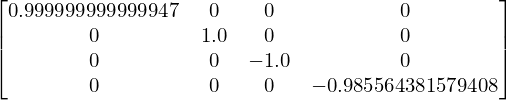

'1/2 # 40'

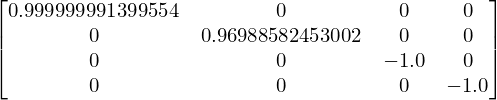

In [4]:
# Check retardance
display(str(names[0]),matrices[0])
display(str(names[3]),matrices[3])

### Compare with theoretical expectations

We compute the effects of ideal half-wave paltes on Stokes vectors for different polarizations to compare with our results from the fits.

In [5]:
S_H=Matrix([1,1,0,0])
S_D=Matrix([1,0,1,0])
S_R=Matrix([1,0,0,1])
matrix_ideal=Matrix([[1,0,0,0],[0,1,0,0],[0,0,-1,0],[0,0,0,-1]])
S_H_prime_0=matrices[0] *S_H
S_H_prime_1=matrices[3]*S_H

S_D_prime_0=matrices[0]*S_D
S_D_prime_1=matrices[3]*S_D

S_R_prime_0=matrices[0]*S_R
S_R_prime_1=matrices[3]*S_R

S_H_ideal=matrix_ideal*S_H
S_D_ideal=matrix_ideal*S_D

delta_H_0 = (S_H[1]-S_H_prime_0[1])
delta_H_1 = (S_H[1]-S_H_prime_1[1])

delta_D_0 = (S_D[2]-S_D_prime_0[2])
delta_D_1 = (S_D[2]-S_D_prime_0[2])

retardance_0= (delta_D_0-delta_H_0)*180/2
retardance_1= (delta_D_1-delta_H_1)*180/2

print(retardance_0)
print(retardance_1)

180.000000000000
177.289724207702


If the half-wave plate acts upon horizontal polarization under the angle $\alpha$=0 there is not much change, which is good

'Horizontal polarization on 1/2 600-2700'

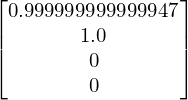

'Horizontal polarization on 1/2 # 40'

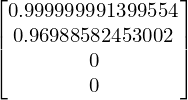

In [6]:
display('Horizontal polarization on '+str(names[0]), S_H_prime_0)   
display('Horizontal polarization on '+str(names[3]), S_H_prime_1)  

If the half-wave plate acts upon diagonal polarization under the angle $\alpha$
=0, the diagonal polarization is flipped

'Diagonal polarization on 1/2 600-2700'

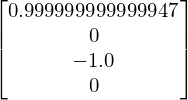

'Diagonal polarization on 1/2 # 40'

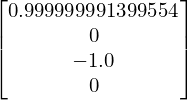

In [7]:
display('Diagonal polarization on '+str(names[0]), S_D_prime_0)   
display('Diagonal polarization on '+str(names[3]), S_D_prime_1)

If the half-wave plate acts upon right-handed polarization under the angle 𝛼 =0, the diagonal polarization is flipped

'Right-handed polarization on 1/2 600-2700'

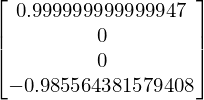

'Right-handed polarization on 1/2 # 40'

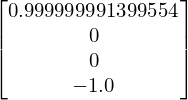

In [8]:
display('Right-handed polarization on '+str(names[0]), S_R_prime_0)   
display('Right-handed polarization on '+str(names[3]), S_R_prime_1)

#print('S_H strich 0',S_H_prime_0/S_H_prime_0[0])
#print('S_D strich 0',S_D_prime_0/S_D_prime_0[0])
#print('S_H strich 1',S_H_prime_1/S_H_prime_1[0])
#print('S_D strich 1',S_D_prime_1/S_D_prime_1[0])
#print('S_H ideal', S_H_ideal)
#print('S_D ideal', S_D_ideal)

# Für erste Matrix

### Calculating retardance from matrix entries
The Müller matrix for any retardance $\delta$ and $\alpha$=0 is
$$\begin{bmatrix}
 1 & 0 & 0 & 0\\
0 & D^2 + G^2 & 0 & 0\\
 0 & 0 & -D^2 + G^2 & 2DG \\
  0 & 0 & -2DG & 2 G^2 -1
\end{bmatrix}$$ with D=$M sin(\frac{1}{2} \delta)$ and G=$cos \frac{1}{2} \delta$

We normalize the intensity to 1 for the computed matrices. To compute the retardance we use some of the entries.
For the half-wave plate 600-2700 nm we get

'1/2 600-2700'

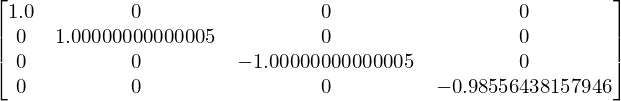

'1/2 # 40'

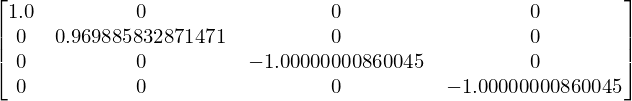

delta from last entry= 2.97147220260531
delta from last entry in degree= 170.252816149727
delta from side entries  0
delta from side entries  0


In [9]:
display(str(names[0]),matrices[0]/matrices[0][0])
display(str(names[3]),matrices[3]/matrices[3][0])

M0=S_i_normalized[0]
#print(-matrices[1][11]/matrices[1][0])

# Compute the retardance from the entries
a=acos(sqrt(((matrices[0][15]/matrices[0][0] +1)/2)))*2
b1=asin((-matrices[0][14]/matrices[0][0])/M0[0])
b2=asin((-matrices[0][11]/matrices[0][0])/M0[0])
print('delta from last entry=',a)
print('delta from last entry in degree=',a/np.pi *180)
print('delta from side entries ', b1)
print('delta from side entries ', b2)

For the other half-wave plate

In [10]:
M0=S_i_normalized[3]
#print(-matrices[1][11]/matrices[1][0])

# Compute the retardance from the entries
a=acos(sqrt(((matrices[3][15]/matrices[3][0] +1)/2)))*2
b1=asin((-matrices[3][14]/matrices[3][0])/M0[3])
b2=asin((-matrices[3][11]/matrices[3][0])/M0[3])
print('delta from last entry=',a)
print('delta from last entry in degree=',a/np.pi *180)
print('delta from side entries ', b1)
print('delta from side entries ', b2)

delta from last entry= 2*acos(6.55760852407342e-5*I)
delta from last entry in degree= 114.591559026165*acos(6.55760852407342e-5*I)
delta from side entries  0
delta from side entries  0
